In [ ]:
import sys
sys.path.append('../src')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics.models.yolo import YOLO

from utils import (
    load_image,
    extract_edge_features,
    detect_keypoints_sift,
    detect_keypoints_orb,
    detect_contours,
    draw_detections,
    draw_enhanced_detections
)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 3.1 Load Image and Model

In [12]:
# Load test image
image_path = "../data/raw/my_dogs.jpg"

if not Path(image_path).exists():
    print("⚠️  Using sample image")
    image = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)
else:
    image = load_image(image_path)

# Load YOLO model
# Using pretrained YOLOv8n model (smallest and fastest)
# It's trained on COCO dataset which includes 'dog' and 'cat' classes
model_path = "../models/yolov8n.pt"
print(f"Loading YOLOv8n model...")
model = YOLO('yolov8n.pt')  # This will auto-download if not present

print(f"✅ Model loaded successfully")
print(f"   Classes: {model.names}")
print(f"\nImage shape: {image.shape}")

Loading YOLOv8n model...
✅ Model loaded successfully
   Classes: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mo

## 3.2 Extract Features

In [13]:
# Extract edge features
edges = extract_edge_features(image)

# Detect keypoints
keypoints_sift, descriptors_sift = detect_keypoints_sift(image, max_keypoints=200)
keypoints_orb, descriptors_orb = detect_keypoints_orb(image, max_keypoints=200)

# Detect contours
contours = detect_contours(image, min_area=500)

print(f"📊 Feature Extraction Results:")
print(f"  • Canny edges: {edges['canny'].sum() // 255} pixels")
print(f"  • SIFT keypoints: {len(keypoints_sift)}")
print(f"  • ORB keypoints: {len(keypoints_orb)}")
print(f"  • Contours: {len(contours)}")

📊 Feature Extraction Results:
  • Canny edges: 62043 pixels
  • SIFT keypoints: 200
  • ORB keypoints: 200
  • Contours: 10


## 3.3 Visualize Edge Detection Results

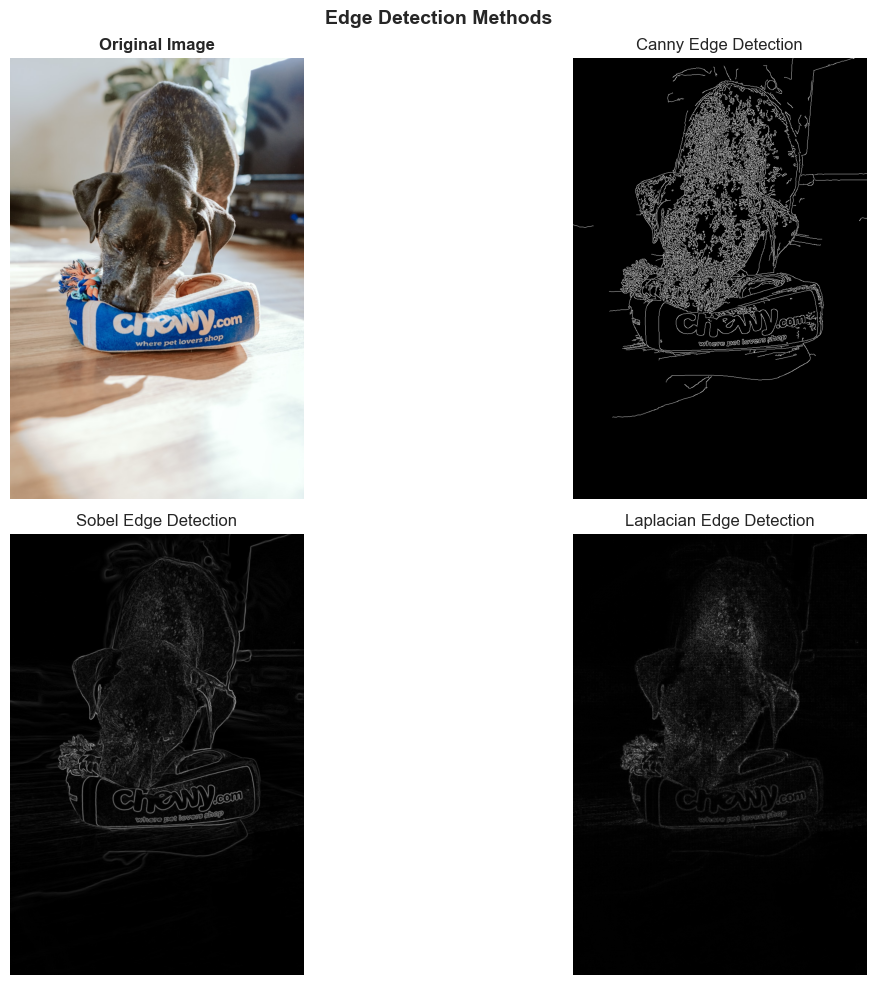

In [14]:
# Convert for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].imshow(image_rgb)
axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(edges['canny'], cmap='gray')
axes[0, 1].set_title('Canny Edge Detection', fontsize=12)
axes[0, 1].axis('off')

axes[1, 0].imshow(edges['sobel'], cmap='gray')
axes[1, 0].set_title('Sobel Edge Detection', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(edges['laplacian'], cmap='gray')
axes[1, 1].set_title('Laplacian Edge Detection', fontsize=12)
axes[1, 1].axis('off')

plt.suptitle('Edge Detection Methods', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.4 Run YOLO Detection

In [18]:
# Run inference
results = model(image, conf=0.25, verbose=False)

# Extract results
result = results[0]
boxes = result.boxes.xyxy.cpu().numpy()
confidences = result.boxes.conf.cpu().numpy()
class_ids = result.boxes.cls.cpu().numpy().astype(int)
class_names = result.names

print(f"\n🐾 Detected {len(boxes)} pet(s):")
for i, (box, class_id, conf) in enumerate(zip(boxes, class_ids, confidences)):
    class_name = class_names[class_id]
    print(f"  {i+1}. {class_name.upper()} - confidence: {conf:.2f}")


🐾 Detected 1 pet(s):
  1. DOG - confidence: 0.73


## 3.5 Compare Standard vs Enhanced Detection

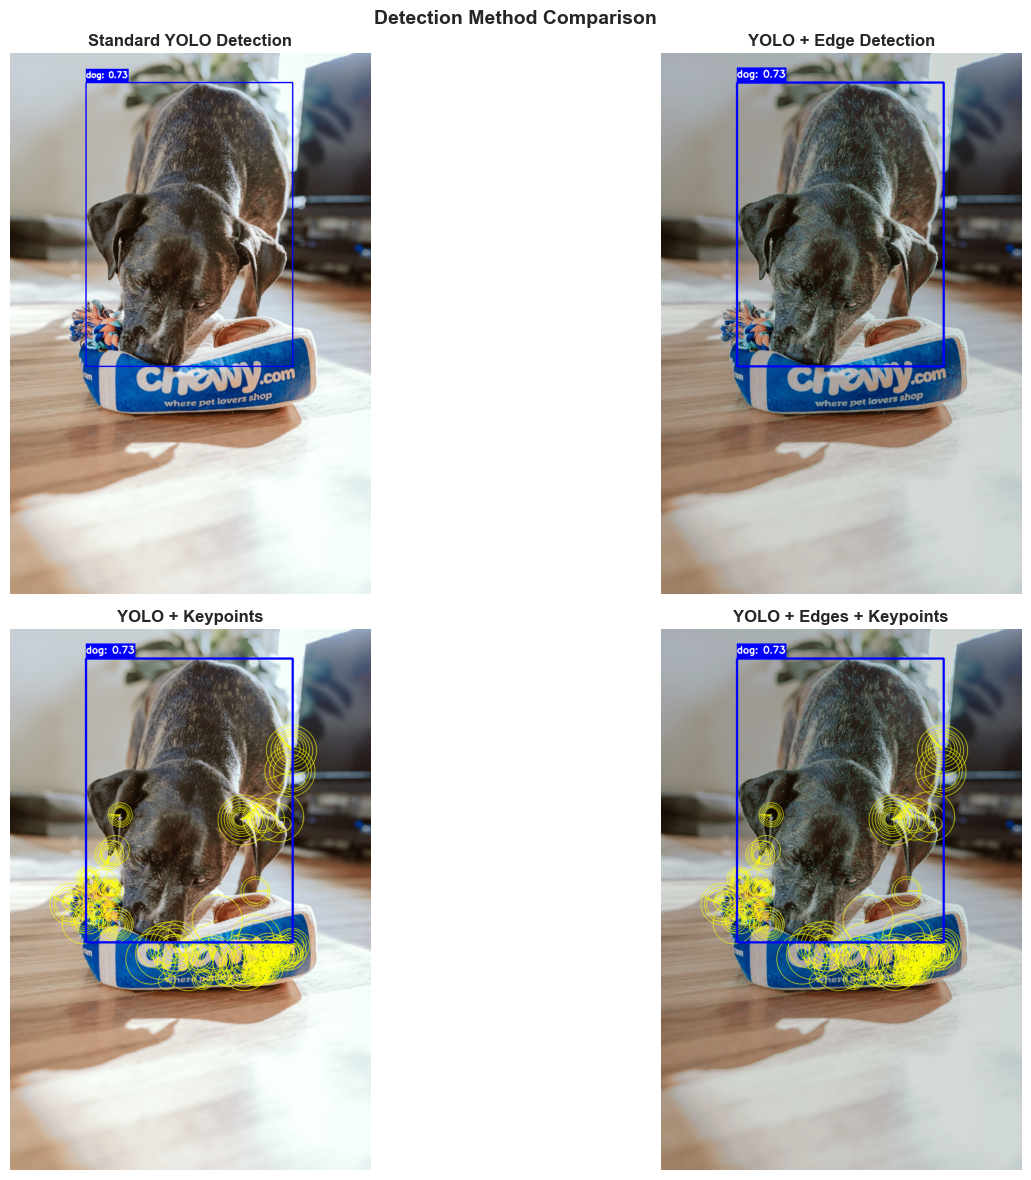

In [16]:
# Standard YOLO detection
standard_output = draw_detections(
    image,
    boxes.tolist(),
    class_names,
    confidences.tolist(),
    class_ids.tolist()
)

# Enhanced detection with edges
enhanced_edges = draw_enhanced_detections(
    image,
    boxes.tolist(),
    class_names,
    confidences.tolist(),
    class_ids.tolist(),
    show_edges=True,
    show_keypoints=False
)

# Enhanced detection with keypoints
enhanced_keypoints = draw_enhanced_detections(
    image,
    boxes.tolist(),
    class_names,
    confidences.tolist(),
    class_ids.tolist(),
    show_edges=False,
    show_keypoints=True
)

# Enhanced detection with both
enhanced_both = draw_enhanced_detections(
    image,
    boxes.tolist(),
    class_names,
    confidences.tolist(),
    class_ids.tolist(),
    show_edges=True,
    show_keypoints=True
)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].imshow(cv2.cvtColor(standard_output, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Standard YOLO Detection', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(enhanced_edges, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('YOLO + Edge Detection', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(cv2.cvtColor(enhanced_keypoints, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title('YOLO + Keypoints', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(cv2.cvtColor(enhanced_both, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title('YOLO + Edges + Keypoints', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

plt.suptitle('Detection Method Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.6 Analyze Detection Regions

In [17]:
# For each detection, analyze the features within the bounding box
for i, (box, class_id, conf) in enumerate(zip(boxes, class_ids, confidences)):
    x1, y1, x2, y2 = map(int, box)
    class_name = class_names[class_id]
    
    # Extract region
    region = image[y1:y2, x1:x2]
    
    # Analyze features in region
    region_edges = extract_edge_features(region)
    region_keypoints_orb, _ = detect_keypoints_orb(region, max_keypoints=100)
    
    print(f"\n{i+1}. {class_name.upper()} Detection Analysis:")
    print(f"   Bounding Box: [{x1}, {y1}] to [{x2}, {y2}]")
    print(f"   Region size: {x2-x1} x {y2-y1} pixels")
    print(f"   Edge pixels (Canny): {region_edges['canny'].sum() // 255}")
    print(f"   ORB keypoints in region: {len(region_keypoints_orb)}")
    print(f"   Confidence: {conf:.2%}")


1. DOG Detection Analysis:
   Bounding Box: [168, 65] to [626, 694]
   Region size: 458 x 629 pixels
   Edge pixels (Canny): 51660
   ORB keypoints in region: 100
   Confidence: 73.13%


## Summary

**What we accomplished:**
- ✅ Integrated YOLOv8 object detection with edge detection
- ✅ Combined multiple computer vision techniques
- ✅ Created enhanced visualization options
- ✅ Analyzed feature distributions in detected regions

**Use cases:**
- Enhanced visual analysis for debugging detection issues
- Feature-rich representations for downstream tasks
- Understanding what the model "sees" in detected regions

**Next steps:**
- Fine-tune YOLO on custom pet dataset
- Add tracking for video streams
- Deploy as a web service